# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


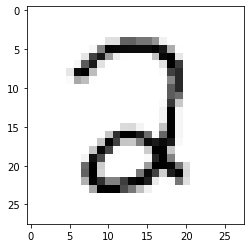

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2558
Training Accuracy: 0.5462, Testing Accuracy: 0.5454



Epoch 10, Loss 0.0838
Training Accuracy: 0.9312, Testing Accuracy: 0.9395



Epoch 20, Loss 0.0499
Training Accuracy: 0.9523, Testing Accuracy: 0.9577



Epoch 30, Loss 0.0394
Training Accuracy: 0.9594, Testing Accuracy: 0.9627



Epoch 40, Loss 0.0342
Training Accuracy: 0.9645, Testing Accuracy: 0.9642



Epoch 50, Loss 0.0309
Training Accuracy: 0.9674, Testing Accuracy: 0.9662



Epoch 60, Loss 0.0286
Training Accuracy: 0.9692, Testing Accuracy: 0.9677



Epoch 70, Loss 0.0269
Training Accuracy: 0.9710, Testing Accuracy: 0.9708



Epoch 80, Loss 0.0255
Training Accuracy: 0.9725, Testing Accuracy: 0.9708



Epoch 90, Loss 0.0243
Training Accuracy: 0.9728, Testing Accuracy: 0.9728



Epoch 100, Loss 0.0234
Training Accuracy: 0.9736, Testing Accuracy: 0.9738



Epoch 110, Loss 0.0225
Training Accuracy: 0.9742, Testing Accuracy: 0.9738



Epoch 120, Loss 0.0217
Training Accuracy: 0.9751, Testing Accuracy: 0.9738



Epoch 130, Loss 0.0211
Training Accuracy: 0.9760, Testing Accuracy: 0.9738



Epoch 140, Loss 0.0204
Training Accuracy: 0.9767, Testing Accuracy: 0.9743



Epoch 150, Loss 0.0198
Training Accuracy: 0.9775, Testing Accuracy: 0.9743



Epoch 160, Loss 0.0193
Training Accuracy: 0.9786, Testing Accuracy: 0.9743



Epoch 170, Loss 0.0188
Training Accuracy: 0.9791, Testing Accuracy: 0.9743



Epoch 180, Loss 0.0183
Training Accuracy: 0.9801, Testing Accuracy: 0.9748



Epoch 190, Loss 0.0179
Training Accuracy: 0.9802, Testing Accuracy: 0.9758



Epoch 200, Loss 0.0174
Training Accuracy: 0.9808, Testing Accuracy: 0.9758



Epoch 210, Loss 0.017
Training Accuracy: 0.9811, Testing Accuracy: 0.9763



Epoch 220, Loss 0.0166
Training Accuracy: 0.9817, Testing Accuracy: 0.9768



Epoch 230, Loss 0.0162
Training Accuracy: 0.9821, Testing Accuracy: 0.9768



Epoch 240, Loss 0.0159
Training Accuracy: 0.9829, Testing Accuracy: 0.9768



0.003938904556792544

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2752
Training Accuracy: 0.5281, Testing Accuracy: 0.5101



Epoch 10, Loss 0.1031
Training Accuracy: 0.9178, Testing Accuracy: 0.9234



Epoch 20, Loss 0.0784
Training Accuracy: 0.9325, Testing Accuracy: 0.9430



Epoch 30, Loss 0.0675
Training Accuracy: 0.9397, Testing Accuracy: 0.9506



Epoch 40, Loss 0.0609
Training Accuracy: 0.9437, Testing Accuracy: 0.9551



Epoch 50, Loss 0.0565
Training Accuracy: 0.9468, Testing Accuracy: 0.9572



Epoch 60, Loss 0.0533
Training Accuracy: 0.9494, Testing Accuracy: 0.9597



Epoch 70, Loss 0.0508
Training Accuracy: 0.9510, Testing Accuracy: 0.9637



Epoch 80, Loss 0.0488
Training Accuracy: 0.9528, Testing Accuracy: 0.9642



Epoch 90, Loss 0.0471
Training Accuracy: 0.9538, Testing Accuracy: 0.9647



Epoch 100, Loss 0.0458
Training Accuracy: 0.9548, Testing Accuracy: 0.9657



Epoch 110, Loss 0.0446
Training Accuracy: 0.9555, Testing Accuracy: 0.9657



Epoch 120, Loss 0.0435
Training Accuracy: 0.9560, Testing Accuracy: 0.9662



Epoch 130, Loss 0.0426
Training Accuracy: 0.9568, Testing Accuracy: 0.9662



Epoch 140, Loss 0.0418
Training Accuracy: 0.9572, Testing Accuracy: 0.9662



Epoch 150, Loss 0.0411
Training Accuracy: 0.9577, Testing Accuracy: 0.9667



Epoch 160, Loss 0.0404
Training Accuracy: 0.9580, Testing Accuracy: 0.9672



Epoch 170, Loss 0.0398
Training Accuracy: 0.9584, Testing Accuracy: 0.9672



Epoch 180, Loss 0.0393
Training Accuracy: 0.9592, Testing Accuracy: 0.9672



Epoch 190, Loss 0.0388
Training Accuracy: 0.9596, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0383
Training Accuracy: 0.9599, Testing Accuracy: 0.9672



Epoch 210, Loss 0.0379
Training Accuracy: 0.9602, Testing Accuracy: 0.9672



Epoch 220, Loss 0.0375
Training Accuracy: 0.9604, Testing Accuracy: 0.9677



Epoch 230, Loss 0.0371
Training Accuracy: 0.9605, Testing Accuracy: 0.9682



Epoch 240, Loss 0.0368
Training Accuracy: 0.9610, Testing Accuracy: 0.9677



0.03167357525704211

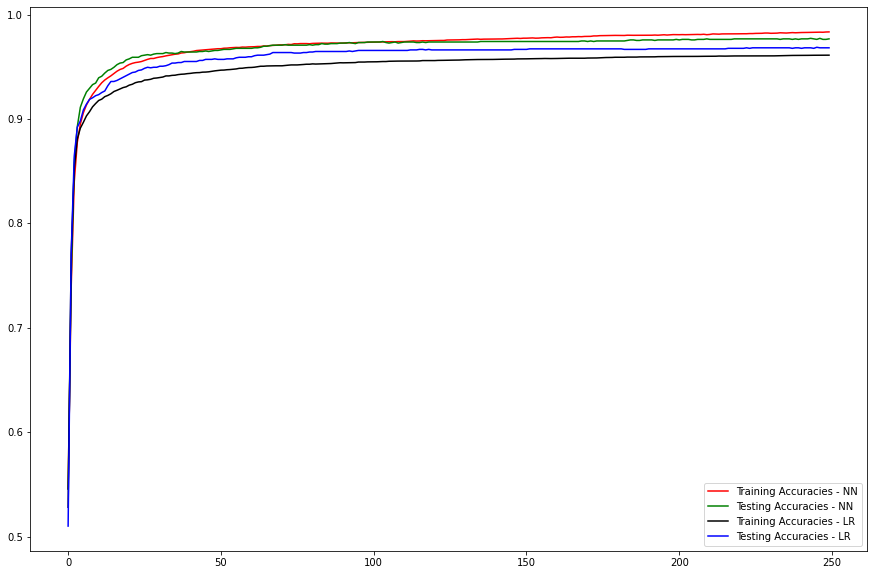

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

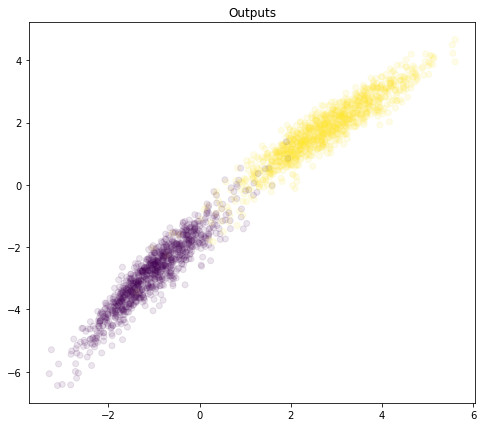

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

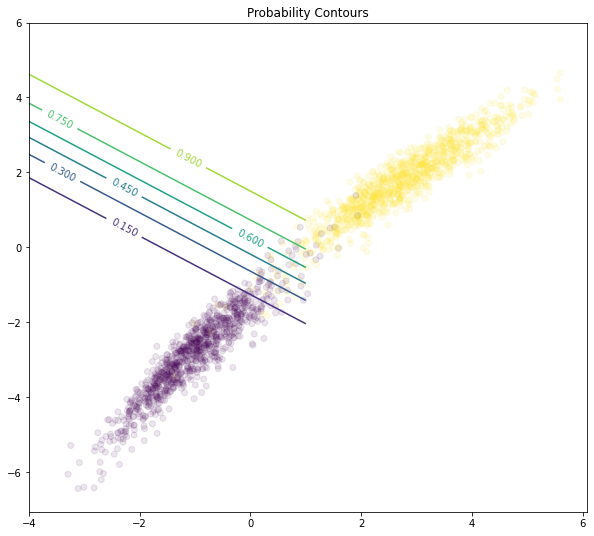

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );